In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from collections import Counter

from transformers import AutoTokenizer, AutoModel
import torch
from torch.utils.data import DataLoader, Dataset

df = pd.read_csv('DataFix_Preprocessed.csv')
rare = df['Rating'].value_counts()[lambda x: x<2].index.tolist()
df = df[~df['Rating'].isin(rare)]

texts  = df['text_clean'].tolist()
labels = df['Rating'].tolist()
X_train, X_test, y_train, y_test = train_test_split(
    texts, labels, test_size=0.2, stratify=labels, random_state=42
)

tokenizer = AutoTokenizer.from_pretrained('indobenchmark/indobert-base-p1')
model     = AutoModel.from_pretrained('indobenchmark/indobert-base-p1').eval()
device    = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

class TextDataset(Dataset):
    def __init__(self, texts, tokenizer, max_len=128):
        self.texts = texts
        self.tok   = tokenizer
        self.maxl  = max_len
    def __len__(self):
        return len(self.texts)
    def __getitem__(self, i):
        enc = self.tok(self.texts[i],
                       padding='max_length',
                       truncation=True,
                       max_length=self.maxl,
                       return_tensors='pt')
        return {
            'input_ids'    : enc['input_ids'].squeeze(0),
            'attention_mask': enc['attention_mask'].squeeze(0)
        }

def embed_texts(texts, batch_size=32):
    ds     = TextDataset(texts, tokenizer)
    loader = DataLoader(ds, batch_size=batch_size)
    embs   = []
    with torch.no_grad():
        for batch in loader:
            inp  = batch['input_ids'].to(device)
            mask = batch['attention_mask'].to(device)
            out  = model(input_ids=inp, attention_mask=mask)
            embs.append(out.last_hidden_state[:,0,:].cpu())
    return torch.cat(embs,0).numpy()

print("Embedding")
Xtr_emb = embed_texts(X_train)
Xte_emb = embed_texts(X_test)
print("Done:", Xtr_emb.shape, Xte_emb.shape)

Embedding
Done: (4301, 768) (1076, 768)


In [2]:
from imblearn.over_sampling import SMOTE

print("Before:", Counter(y_train))
max_n   = max(Counter(y_train).values())
strategy = {cls: max_n for cls in [1,2,5] if cls in y_train}
sm       = SMOTE(random_state=42, sampling_strategy=strategy)

X_res, y_res = sm.fit_resample(Xtr_emb, y_train)
print("After SMOTE:", Counter(y_res))

from sklearn.preprocessing import MinMaxScaler
scaler    = MinMaxScaler()
X_res_nb  = scaler.fit_transform(X_res)
Xte_nb    = scaler.transform(Xte_emb)

Before: Counter({3: 2972, 4: 1192, 2: 91, 5: 31, 1: 15})
After SMOTE: Counter({3: 2972, 1: 2972, 2: 2972, 5: 2972, 4: 1192})


              precision    recall  f1-score   support

           1     0.0588    0.5000    0.1053         4
           2     0.0563    0.5455    0.1021        22
           3     0.8260    0.5040    0.6260       744
           4     0.6391    0.4933    0.5568       298
           5     0.0483    0.8750    0.0915         8

    accuracy                         0.5046      1076
   macro avg     0.3257    0.5836    0.2964      1076
weighted avg     0.7499    0.5046    0.5902      1076



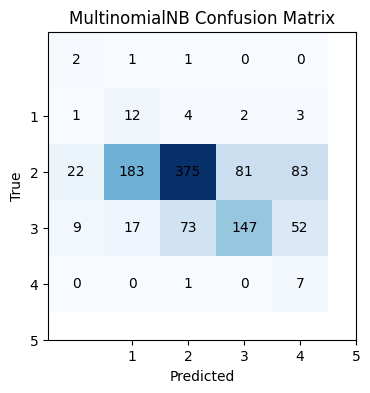

In [3]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

clf = MultinomialNB()
clf.fit(X_res_nb, y_res)
y_pred = clf.predict(Xte_nb)

print(classification_report(y_test, y_pred, digits=4))

cm = confusion_matrix(y_test, y_pred, labels=sorted(set(y_test)))
plt.figure(figsize=(5,4))
plt.imshow(cm, cmap='Blues', interpolation='nearest')
plt.title("MultinomialNB Confusion Matrix")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.xticks(np.arange(1,6), np.arange(1,6))
plt.yticks(np.arange(1,6), np.arange(1,6))
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i,j], ha='center', va='center')
plt.show()

              precision    recall  f1-score   support

           1     0.0857    0.7500    0.1538         4
           2     0.0496    0.3182    0.0859        22
           3     0.8007    0.6102    0.6926       744
           4     0.7325    0.3859    0.5055       298
           5     0.0398    0.8750    0.0761         8

    accuracy                         0.5446      1076
   macro avg     0.3417    0.5879    0.3028      1076
weighted avg     0.7581    0.5446    0.6218      1076



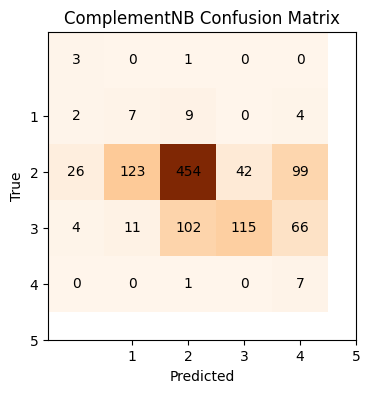

In [4]:
# 4. ComplementNB
from sklearn.naive_bayes import ComplementNB

clf = ComplementNB()
clf.fit(X_res_nb, y_res)
y_pred = clf.predict(Xte_nb)

print(classification_report(y_test, y_pred, digits=4))

cm = confusion_matrix(y_test, y_pred, labels=sorted(set(y_test)))
plt.figure(figsize=(5,4))
plt.imshow(cm, cmap='Oranges', interpolation='nearest')
plt.title("ComplementNB Confusion Matrix")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.xticks(np.arange(1,6), np.arange(1,6))
plt.yticks(np.arange(1,6), np.arange(1,6))
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i,j], ha='center', va='center')
plt.show()


c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


              precision    recall  f1-score   support

           1     0.0000    0.0000    0.0000         4
           2     0.1628    0.3182    0.2154        22
           3     0.8752    0.8105    0.8416       744
           4     0.6526    0.7248    0.6868       298
           5     0.1250    0.1250    0.1250         8

    accuracy                         0.7686      1076
   macro avg     0.3631    0.3957    0.3738      1076
weighted avg     0.7901    0.7686    0.7775      1076



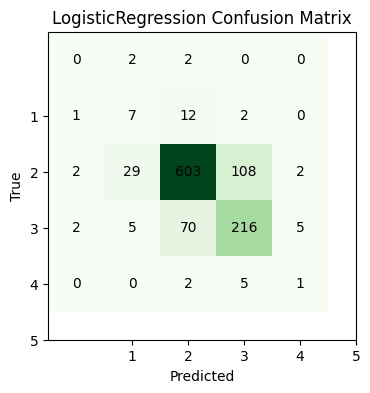

In [5]:
# 5. LogisticRegression
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(
    multi_class='multinomial', solver='lbfgs',
    class_weight='balanced', max_iter=1000, random_state=42
)
clf.fit(X_res, y_res)
y_pred = clf.predict(Xte_emb)

print(classification_report(y_test, y_pred, digits=4))

cm = confusion_matrix(y_test, y_pred, labels=sorted(set(y_test)))
plt.figure(figsize=(5,4))
plt.imshow(cm, cmap='Greens', interpolation='nearest')
plt.title("LogisticRegression Confusion Matrix")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.xticks(np.arange(1,6), np.arange(1,6))
plt.yticks(np.arange(1,6), np.arange(1,6))
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i,j], ha='center', va='center')
plt.show()


              precision    recall  f1-score   support

           1     0.0000    0.0000    0.0000         4
           2     0.1905    0.3636    0.2500        22
           3     0.8776    0.8387    0.8577       744
           4     0.7007    0.7148    0.7076       298
           5     0.2308    0.3750    0.2857         8

    accuracy                         0.7881      1076
   macro avg     0.3999    0.4584    0.4202      1076
weighted avg     0.8065    0.7881    0.7963      1076



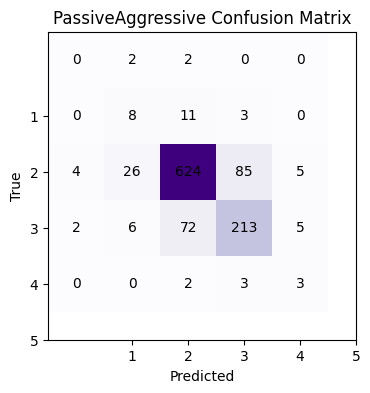

In [6]:
# 6. PassiveAggressiveClassifier
from sklearn.linear_model import PassiveAggressiveClassifier

clf = PassiveAggressiveClassifier(
    max_iter=1000, class_weight='balanced', random_state=42
)
clf.fit(X_res, y_res)
y_pred = clf.predict(Xte_emb)

print(classification_report(y_test, y_pred, digits=4))

cm = confusion_matrix(y_test, y_pred, labels=sorted(set(y_test)))
plt.figure(figsize=(5,4))
plt.imshow(cm, cmap='Purples', interpolation='nearest')
plt.title("PassiveAggressive Confusion Matrix")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.xticks(np.arange(1,6), np.arange(1,6))
plt.yticks(np.arange(1,6), np.arange(1,6))
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i,j], ha='center', va='center')
plt.show()


              precision    recall  f1-score   support

           1     0.0000    0.0000    0.0000         4
           2     0.2059    0.3182    0.2500        22
           3     0.8682    0.8414    0.8546       744
           4     0.6752    0.7114    0.6928       298
           5     0.0000    0.0000    0.0000         8

    accuracy                         0.7853      1076
   macro avg     0.3499    0.3742    0.3595      1076
weighted avg     0.7915    0.7853    0.7879      1076



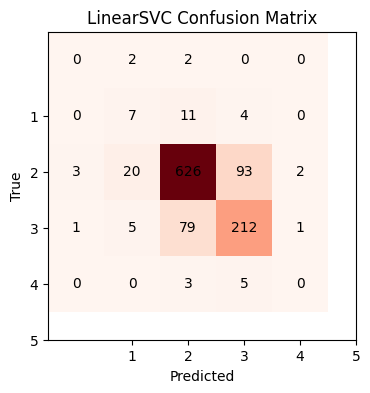

In [7]:
# 7. LinearSVC
from sklearn.svm import LinearSVC

clf = LinearSVC(
    max_iter=10000, class_weight='balanced', random_state=42
)
clf.fit(X_res, y_res)
y_pred = clf.predict(Xte_emb)

print(classification_report(y_test, y_pred, digits=4))

cm = confusion_matrix(y_test, y_pred, labels=sorted(set(y_test)))
plt.figure(figsize=(5,4))
plt.imshow(cm, cmap='Reds', interpolation='nearest')
plt.title("LinearSVC Confusion Matrix")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.xticks(np.arange(1,6), np.arange(1,6))
plt.yticks(np.arange(1,6), np.arange(1,6))
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i,j], ha='center', va='center')
plt.show()


In [9]:
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold

param_dist = {
    'C': np.logspace(-4,4,20),
    'solver': ['lbfgs','saga']
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
base_lr = LogisticRegression(
    multi_class='multinomial',
    class_weight='balanced',
    max_iter=2000,
    random_state=42
)
rs = RandomizedSearchCV(
    base_lr, param_dist, n_iter=20, scoring='f1_macro',
    cv=cv, n_jobs=-1, random_state=42
)
rs.fit(X_res, y_res)

print("Best LR params:", rs.best_params_)
print("Best CV f1_macro:", rs.best_score_)

clf_lr = rs.best_estimator_

c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Best LR params: {'solver': 'saga', 'C': np.float64(0.23357214690901212)}
Best CV f1_macro: 0.904535230743539


c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



Classification Report (Test):
              precision    recall  f1-score   support

           1     0.0000    0.0000    0.0000         4
           2     0.1591    0.3182    0.2121        22
           3     0.8688    0.8185    0.8429       744
           4     0.6624    0.6980    0.6797       298
           5     0.1667    0.2500    0.2000         8

    accuracy                         0.7677      1076
   macro avg     0.3714    0.4169    0.3870      1076
weighted avg     0.7887    0.7677    0.7769      1076



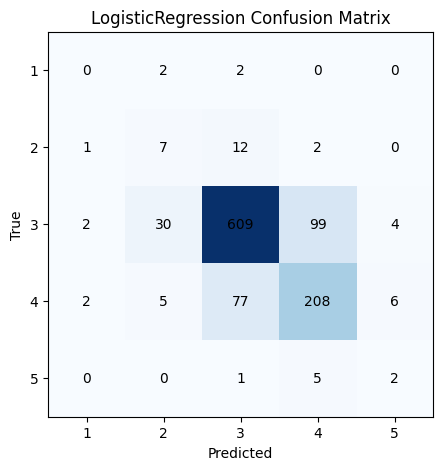

In [10]:
y_pred = clf_lr.predict(Xte_emb)
print("\nClassification Report (Test):")
print(classification_report(y_test, y_pred, digits=4))

cm = confusion_matrix(y_test, y_pred, labels=sorted(set(y_test)))
plt.figure(figsize=(6,5))
plt.imshow(cm, cmap='Blues', interpolation='nearest')
plt.title("LogisticRegression Confusion Matrix")
plt.xlabel("Predicted"); plt.ylabel("True")
labels_unique = sorted(set(y_test))
plt.xticks(np.arange(len(labels_unique)), labels_unique)
plt.yticks(np.arange(len(labels_unique)), labels_unique)
for i in range(len(labels_unique)):
    for j in range(len(labels_unique)):
        plt.text(j, i, cm[i,j], ha='center', va='center')
plt.show()

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.metrics import classification_report, confusion_matrix


param_dist = {'alpha': np.logspace(-3, 1, 20)}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rs_mnb = RandomizedSearchCV(
    MultinomialNB(),
    param_distributions=param_dist,
    n_iter=10,
    scoring='f1_macro',
    cv=cv,
    n_jobs=-1,
    random_state=42
)
rs_mnb.fit(X_res, y_res)

print("=== MultinomialNB Tuning ===")
print("Best alpha:", rs_mnb.best_params_['alpha'])
print("Best CV f1_macro:", rs_mnb.best_score_)

ValueError: 
All the 50 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
50 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\naive_bayes.py", line 762, in fit
    self._count(X, Y)
  File "c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\naive_bayes.py", line 889, in _count
    check_non_negative(X, "MultinomialNB (input X)")
  File "c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py", line 1827, in check_non_negative
    raise ValueError(f"Negative values in data passed to {whom}.")
ValueError: Negative values in data passed to MultinomialNB (input X).


In [ ]:
clf_mnb = rs_mnb.best_estimator_
y_pred_mnb = clf_mnb.predict(X_test)

print("\nClassification Report (MultinomialNB):")
print(classification_report(y_test, y_pred_mnb, digits=4))

# Plot Confusion Matrix
labels_unique = sorted(set(y_test))
cm_mnb = confusion_matrix(y_test, y_pred_mnb, labels=labels_unique)

plt.figure(figsize=(5,4))
plt.imshow(cm_mnb, cmap='Blues', interpolation='nearest')
plt.title("MultinomialNB Confusion Matrix")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.xticks(ticks=np.arange(len(labels_unique)), labels=labels_unique)
plt.yticks(ticks=np.arange(len(labels_unique)), labels=labels_unique)
for i in range(len(labels_unique)):
    for j in range(len(labels_unique)):
        plt.text(j, i, cm_mnb[i, j], ha='center', va='center')
plt.show()


In [ ]:
clf_mnb = rs_mnb.best_estimator_
y_pred_mnb = clf_mnb.predict(Xte_nb)

print("\nClassification Report (MultinomialNB):")
print(classification_report(y_test, y_pred_mnb, digits=4))

# Confusion Matrix
labels_unique = sorted(set(y_test))
cm_mnb = confusion_matrix(y_test, y_pred_mnb, labels=labels_unique)
plt.figure(figsize=(5,4))
plt.imshow(cm_mnb, cmap='Blues', interpolation='nearest')
plt.title("MultinomialNB Confusion Matrix")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.xticks(ticks=np.arange(len(labels_unique)), labels=labels_unique)
plt.yticks(ticks=np.arange(len(labels_unique)), labels=labels_unique)
for i in range(len(labels_unique)):
    for j in range(len(labels_unique)):
        plt.text(j, i, cm_mnb[i, j], ha='center', va='center')
plt.show()

# --------------------------------
# 3. Hyperparameter tuning ComplementNB
# --------------------------------
rs_cnb = RandomizedSearchCV(
    ComplementNB(),
    param_distributions=param_dist,
    n_iter=10,
    scoring='f1_macro',
    cv=cv,
    n_jobs=-1,
    random_state=42
)
rs_cnb.fit(X_res_nb, y_res)

print("\n=== ComplementNB Tuning ===")
print("Best alpha:", rs_cnb.best_params_['alpha'])
print("Best CV f1_macro:", rs_cnb.best_score_)

# Evaluation on test set
clf_cnb = rs_cnb.best_estimator_
y_pred_cnb = clf_cnb.predict(Xte_nb)

print("\nClassification Report (ComplementNB):")
print(classification_report(y_test, y_pred_cnb, digits=4))

# Confusion Matrix
cm_cnb = confusion_matrix(y_test, y_pred_cnb, labels=labels_unique)
plt.figure(figsize=(5,4))
plt.imshow(cm_cnb, cmap='Oranges', interpolation='nearest')
plt.title("ComplementNB Confusion Matrix")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.xticks(ticks=np.arange(len(labels_unique)), labels=labels_unique)
plt.yticks(ticks=np.arange(len(labels_unique)), labels=labels_unique)
for i in range(len(labels_unique)):
    for j in range(len(labels_unique)):
        plt.text(j, i, cm_cnb[i, j], ha='center', va='center')
plt.show()